# Fitting a Non-Linear Model to Data

In [1]:
%pylab inline
%config InlineBackend.figure_format='retina'

Populating the interactive namespace from numpy and matplotlib


In [61]:
import daft
import pystan
import seaborn as sns

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

## A Basic Example

Here we are going to demonstrate a principled way to do "non-linear curve fitting."  Really we are (sneakily) showing how to do astrophysical model building, but it will be phrased as a desire to fit a "curve" to some data points with measurement error.  For our concrete example, we will be fitting the (theorists) [main sequence](https://en.wikipedia.org/wiki/Main_sequence) for stars undergoing core hydrogen burning.  Such stars have a power-law relationship between their temperature and luminosity:
$$
L \simeq L_\odot \left(\frac{T}{T_\odot}\right)^\beta,
$$
with $\beta \simeq 28/3$.  On a log-log plot of luminosity versus temperature (i.e. the theorists [Hertzsprung-Russell diagram](https://en.wikipedia.org/wiki/Hertzsprung–Russell_diagram)), they occupy a line.  We wish to fit for the parameter $\beta$ from (noisy) observations of $L$ and $T$ for many stars. 

The model we will build is the following: we have a data set comprised of measurements of temperature and luminosity on a number of stars.

1. Each star has a true temperature, $T_\mathrm{true}$, and a true luminosity, $L_\mathrm{true}$, which are related by
$$
\frac{L_\mathrm{true}}{L_\odot} = \left(\frac{T_\mathrm{true}}{T_\odot}\right)^\beta.
$$
1. The measured luminosity is log-normally distributed about the true luminosity with an uncertainty of 25% (in practice, this uncertainty is usually driven by the *distance* uncertainty to the star, since we measure *fluxes* with small uncertainty):
$$
\log L_\mathrm{obs} \sim N\left( \log L_\mathrm{true}, 0.25 \right),
$$
where $N(\mu, \sigma)$ is the normal (Gaussian) distribution with mean $\mu$ and s.d. $\sigma$.
1. The measured temperature is normally distributed about the true temperature with an uncertainty of $100 \, \mathrm{K}$ (this is a typical grid spacing in models of stellar atmospheres, and therefore a reasonable uncertainty for the temperature).
$$
T_\mathrm{obs} \sim N\left( T_\mathrm{true} , 100 \, \mathrm{K} \right)
$$
In "solar units" the uncertainty in temperature is $100 \, \mathrm{K} = 0.017 \, T_\odot$.
1. For the moment, we will assume that the population of stars we are observing is distributed uniformly in temperature between $0.8 \, T_\odot$ and $3 \, T_\odot$ (roughly this corresponds to the range of temperatures from the "K" spectral class to the "B" spectral class).

We can combine these assumptions into a fully generative model for our data set.  The model can be represented by the graph below, which traces the statistical dependency of variables:

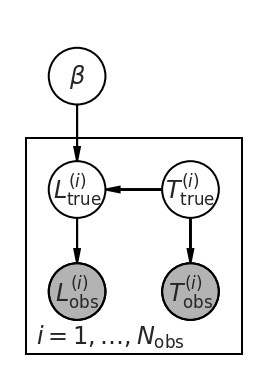

In [62]:
pgm = daft.PGM((2, 3))
pgm.add_node(daft.Node('beta', r'$\beta$', 0.5, 2.5))
pgm.add_node(daft.Node('Ttrue', r'$T_\mathrm{true}^{(i)}$', 1.5, 1.5))
pgm.add_node(daft.Node('Ltrue', r'$L_\mathrm{true}^{(i)}$', 0.5, 1.5))
pgm.add_node(daft.Node('Tobs', r'$T_\mathrm{obs}^{(i)}$', 1.5, 0.6, observed=True))
pgm.add_node(daft.Node('Lobs', r'$L_\mathrm{obs}^{(i)}$', 0.5, 0.6, observed=True))
pgm.add_plate(daft.Plate([0.05, 0.05, 1.9, 1.9], label=r'$i = 1, \ldots, N_\mathrm{obs}$'))
pgm.add_edge('beta', 'Ltrue')
pgm.add_edge('Ttrue', 'Ltrue')
pgm.add_edge('Ltrue', 'Lobs')
pgm.add_edge('Ttrue', 'Tobs')
pgm.render()

It can be a bit tricky to learn how to read these graphical models; for example, focusing on the node for $L_\mathrm{true}^{(i)}$, we would say "if we know the value of $\beta$ and $T_\mathrm{true}^{(i)}$ then we can predict the statistics of $L_\mathrm{true}^{(i)}$."  From the above, we actually know that $L_\mathrm{true}$ is given a delta-function distribution about the value implied by the formula above involving $\beta$ and $T_\mathrm{true}$.  

The model is encoded in the attached [Stan](http://mc-stan.org) program ``main-sequence.stan``.

In [49]:
main_seq_model = pystan.StanModel(file='main-sequence.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ba16fe493e2339f7cf6353a6590618fd NOW.


Let's generate a data set that is drawn from our model:

In [55]:
sigma_T = 0.017 # Solar units
sigma_logL = 0.25

beta_true = 28.0/3.0

Nobs = 15

Ts_true = random.uniform(low=0.8, high=3, size=Nobs)
Ls_true = Ts_true**beta_true
logLs_true = log(Ls_true)

Ts_obs = Ts_true + sigma_T*randn(Nobs)
logLs_obs = logLs_true + sigma_logL*randn(Nobs)

A plot of our data set (note that I haven't reversed the $x$ axis, so the main sequence runs "backwards" from the usual plot).

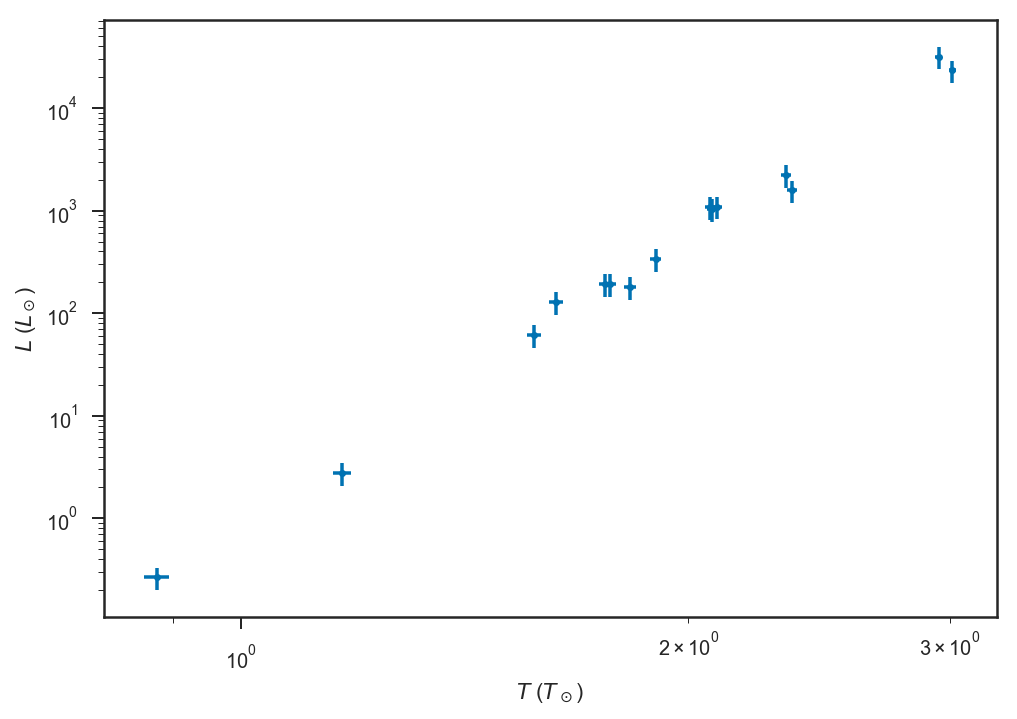

In [63]:
errorbar(Ts_obs, exp(logLs_obs), xerr=sigma_T, yerr=sigma_logL*exp(logLs_obs), fmt='.')
xscale('log')
yscale('log')
xlabel(r'$T$ ($T_\odot$)')
ylabel(r'$L$ ($L_\odot$)')

Now we need to put the data in a format that Stan can understand:

In [57]:
ms_data = {
    'Nobs': Nobs,
    'logLobs': logLs_obs,
    'sigma_logL': sigma_logL*ones_like(logLs_obs),
    'Tobs': Ts_obs,
    'sigma_Tobs': sigma_T*ones_like(Ts_obs)
}

And we fit the data:

In [58]:
ms_fit = main_seq_model.sampling(data=ms_data)

/Users/farr/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


It is useful to check whether the fit has converged with some basic diagnostics.  By default, Stan will report the [Gelman-Rubin convergence statistic](http://dx.doi.org/10.1088/1751-8113/44/8/085201) (R = 1 when multiple chains have mixed well) and the [effective sample size](https://www.math.nyu.edu/faculty/goodman/software/acor/) which takes into account correlations between successive MCMC samples.

In [59]:
ms_fit

Inference for Stan model: anon_model_ba16fe493e2339f7cf6353a6590618fd.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta           9.25  1.6e-3    0.1   9.06   9.19   9.25   9.32   9.45   4000    1.0
Ttrue[0]       2.34  2.6e-4   0.02   2.31   2.33   2.34   2.35   2.37   4000    1.0
Ttrue[1]        1.9  2.5e-4   0.02   1.87   1.89    1.9   1.91   1.93   4000    1.0
Ttrue[2]       2.08  2.5e-4   0.02   2.05   2.07   2.08   2.09   2.11   4000    1.0
Ttrue[3]       2.07  2.5e-4   0.02   2.04   2.06   2.07   2.08    2.1   4000    1.0
Ttrue[4]       0.87  2.2e-4   0.01   0.85   0.86   0.87   0.88    0.9   4000    1.0
Ttrue[5]       1.77  2.5e-4   0.02   1.74   1.76   1.77   1.78    1.8   4000    1.0
Ttrue[6]       1.82  2.5e-4   0.02   1.79   1.81   1.82   1.83   1.85   4000    1.0
Ttrue[7]       1.16  2.4e-4   0.02   1.13   1.15   1.16

We can also get a chainplot, which shows good mixing by eye in the $\beta$ parameter (it is harder to tell with the other parameters).

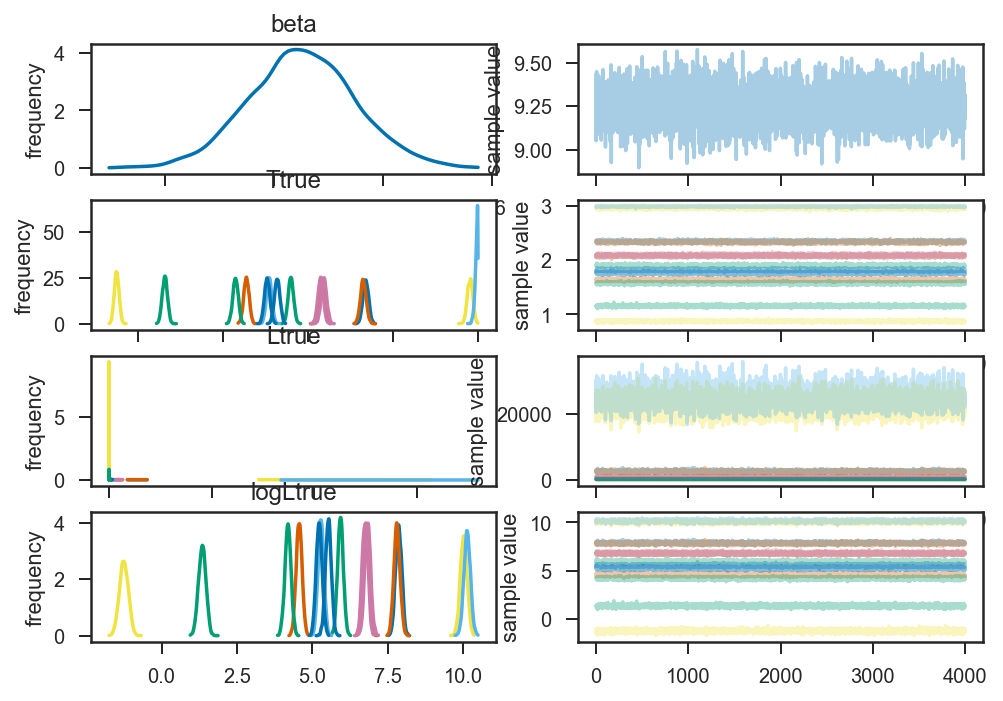

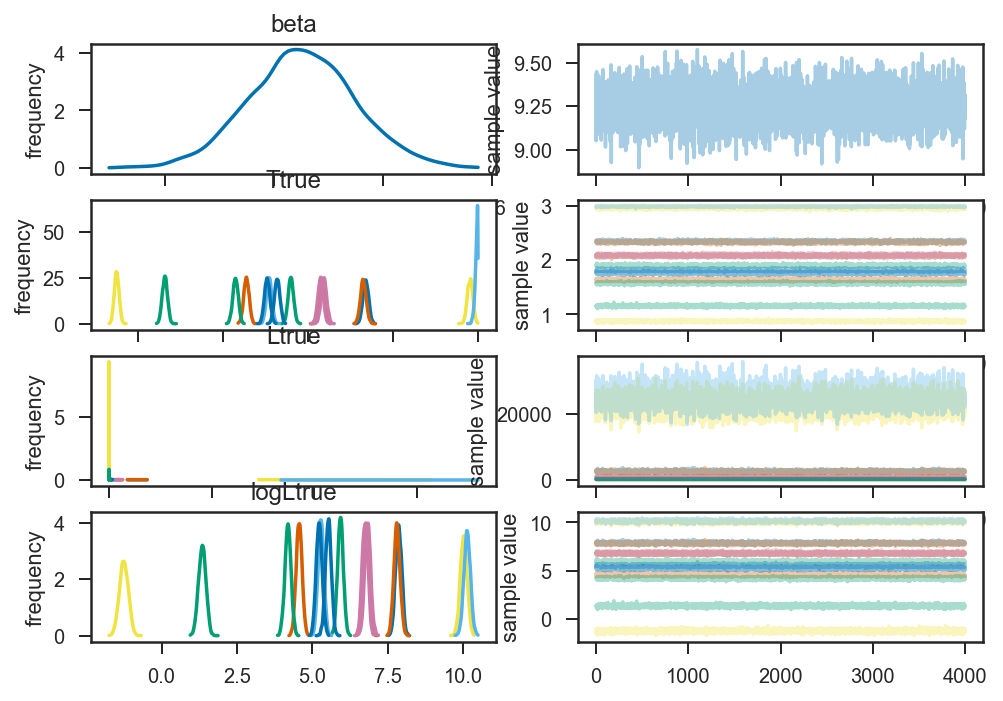

In [64]:
ms_fit.plot()

In [65]:
ms_chain = ms_fit.extract()

We can check that we recover the "correct" value of $\beta$:

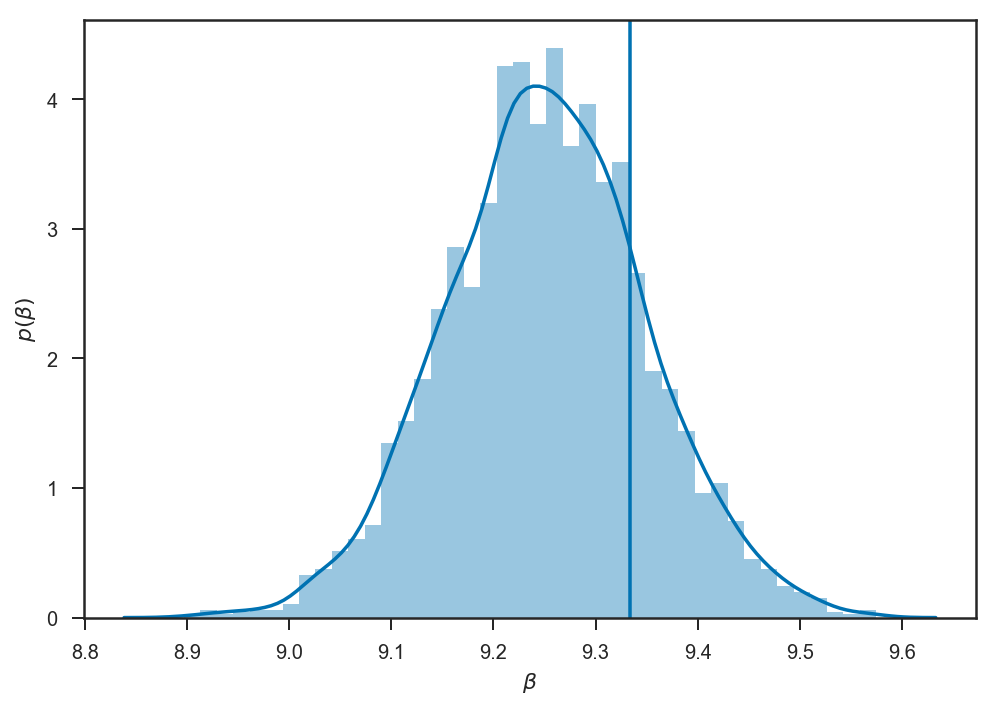

In [67]:
sns.distplot(ms_chain['beta'])
axvline(28/3, color=sns.color_palette()[0])
xlabel(r'$\beta$')
ylabel(r'$p(\beta)$')

Let's plot the implications of our model in data space (because we have *fixed* the model to run through $L = 1$ when $T = 1$, we have a somewhat unusual shape of the uncertainty).  We will plot the posterior median and 1- and 2-sigma bands on the $L$-$T$ relation on top of the data:

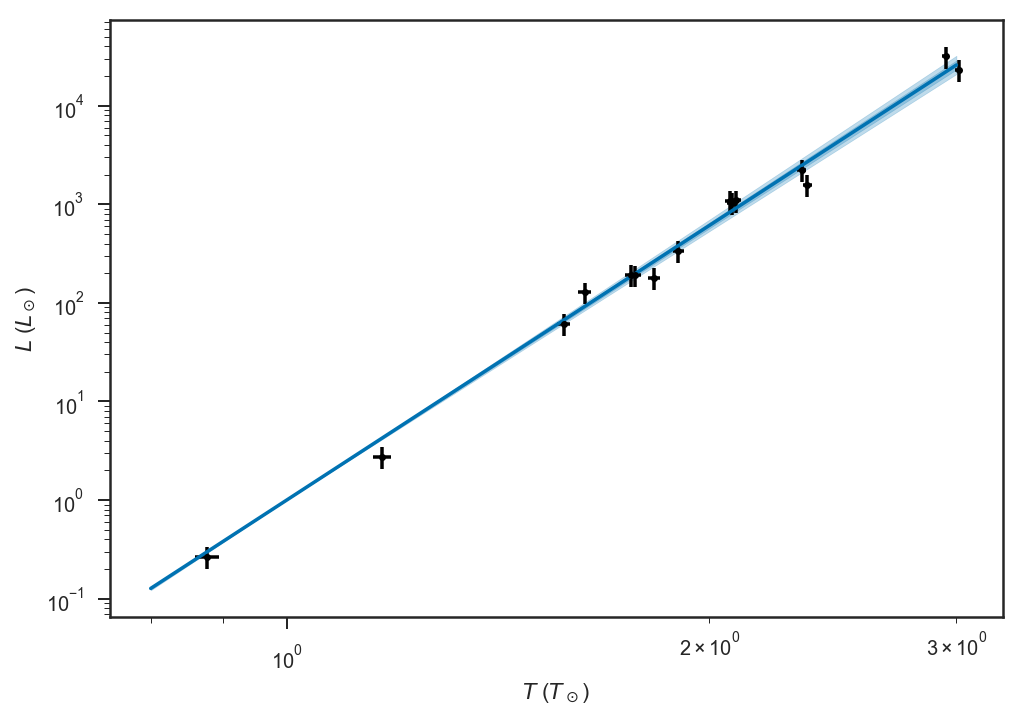

In [69]:
Ts_plot = linspace(0.8, 3, 100)
Ls_plot = []
for b in ms_chain['beta']:
    Ls_plot.append(Ts_plot**b)
Ls_plot = array(Ls_plot)

errorbar(Ts_obs, exp(logLs_obs), xerr=sigma_T, yerr=sigma_logL*exp(logLs_obs), fmt='.', color='k')
plot(Ts_plot, median(Ls_plot, axis=0))
fill_between(Ts_plot, percentile(Ls_plot, 84, axis=0), percentile(Ls_plot, 16, axis=0), color=sns.color_palette()[0], alpha=0.25)
fill_between(Ts_plot, percentile(Ls_plot, 97.5, axis=0), percentile(Ls_plot, 2.5, axis=0), color=sns.color_palette()[0], alpha=0.25)
xscale('log')
yscale('log')
xlabel(r'$T$ ($T_\odot$)')
ylabel(r'$L$ ($L_\odot$)')

Can we use the model to get better estimates of $L$ and $T$ for each star?  Yes!  Because the model specifies a relation between $L$ and $T$ (with some small uncertainty---the band in the plot above is much narrower, particularly at low $L$ and $T$, than the typical observation), it allows us to "transfer" information between measurements of these variables.  In particular, since $T$ is measured much more precisely than $L$, we expect to improve measurements of $L$.  Roughly, with an exponent $\sim 9$, we have 
$$
\frac{\sigma_L}{L} \simeq \beta \frac{\sigma_T}{T} \simeq 0.1
$$
using the relation, compared to $\sigma_L/L \simeq 0.25$ from the observations alone.  

Stan has already inferred the model posterior on $L$ and $T$ for the stars; let's check that it's narrower than the uncertainty on the observed value (shown by the black band):

<Container object of 3 artists>

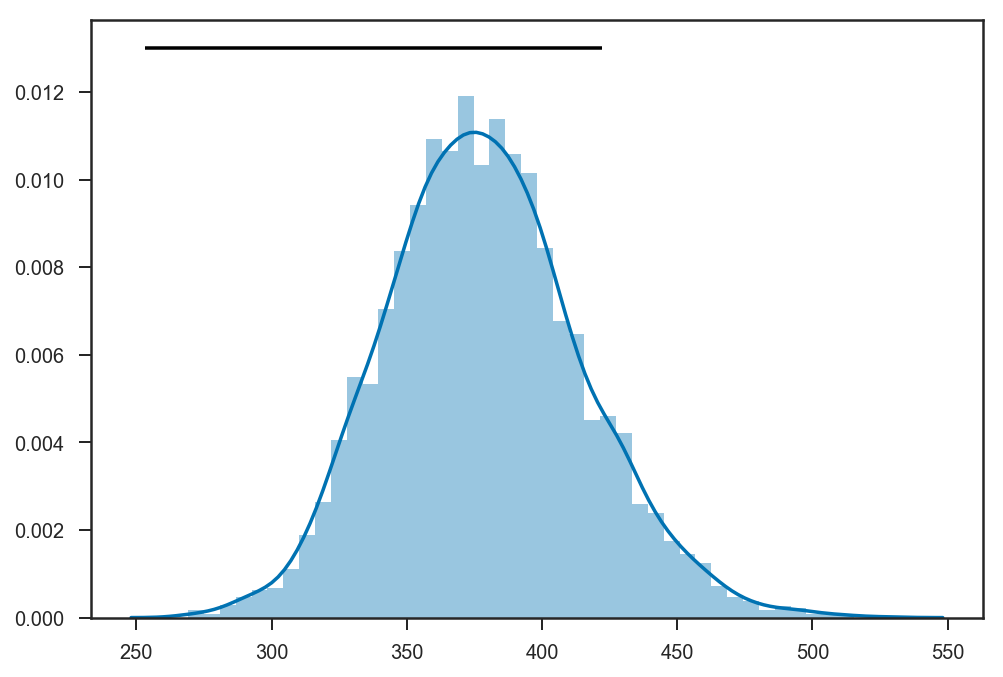

In [74]:
sns.distplot(ms_chain['Ltrue'][:,1])
errorbar(exp(logLs_obs[1]), 0.013, xerr=sigma_logL*exp(logLs_obs[1]), color='k')

## Allowing For Scatter

Real stars don't follow the main sequence relationship (which, in fact, is more complicated than the simple power law we follow here) perfectly.  A number of physical effects, most prominently metallicity, act to give the main sequence some "width."  Here we will implement this as a model scatter term.  A scatter term is appropriate any time you do not expect the model to match the ground truth perfectly.  Here we will assume that, for any particular star, there is an additional $25\%$ "scatter" is the luminosity-temperature relation (equal to the observational uncertainty), so that point 1 above is modified to 
$$
\frac{L_\mathrm{true}}{L_\odot} = \left(\frac{T_\mathrm{true}}{T_\odot}\right)^\beta \times LN\left( 0, 0.25 \right)
$$
where $LN\left( \mu, \sigma \right)$ represents a log-normal distribution with mean (in the log) $\mu$ and s.d. (in the log) $\sigma$.  We will fit for the amount of scatter at the same time as we fit for the slope and the true $T$ and $L$ for each star.  The model is represented in ``ms-scatter.stan``:

In [80]:
ms_scatter_model = pystan.StanModel(file='ms-scatter.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b801656cc6dfaf04272b0fbc6c8a8762 NOW.


Now we generate some data according to this new model:

In [116]:
sigma_T = 0.017 # Solar units
sigma_logL = 0.25
sigma_scatter = 0.25

beta_true = 28.0/3.0

Nobs = 15

Ts_true = random.uniform(low=0.8, high=3, size=Nobs)
Ls_true = Ts_true**beta_true*exp(sigma_scatter*randn(Nobs))
logLs_true = log(Ls_true)

Ts_obs = Ts_true + sigma_T*randn(Nobs)
logLs_obs = logLs_true + sigma_logL*randn(Nobs)

A plot of the data:

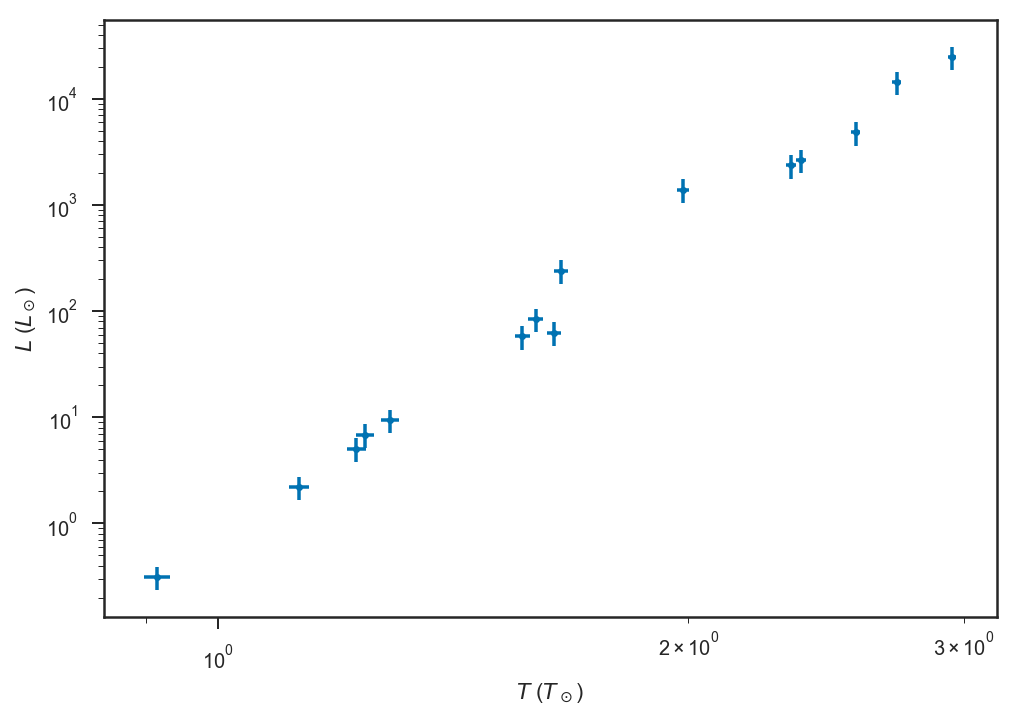

In [117]:
errorbar(Ts_obs, exp(logLs_obs), xerr=sigma_T, yerr=sigma_logL*exp(logLs_obs), fmt='.')
xscale('log')
yscale('log')
xlabel(r'$T$ ($T_\odot$)')
ylabel(r'$L$ ($L_\odot$)')

In [118]:
ms_scatter_data = {
    'Nobs': Nobs,
    'logLobs': logLs_obs,
    'sigma_logL': sigma_logL*ones_like(logLs_obs),
    'Tobs': Ts_obs,
    'sigma_Tobs': sigma_T*ones_like(Ts_obs)
}

It turns out that this model is a bit harder to sample from (if you want to know why, the problem is described in Section 28.6 of the [Stan manual](http://mc-stan.org/users/documentation/index.html); this is a classic example of Neal's funnel).  The sampling issues can be cured by a re-parameterisation, described there, but in simple cases like this, it's easier to just draw more samples:

In [119]:
ms_scatter_fit = ms_scatter_model.sampling(data=ms_scatter_data, iter=16000, thin=8)

/Users/farr/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [120]:
ms_scatter_fit

Inference for Stan model: anon_model_b801656cc6dfaf04272b0fbc6c8a8762.
4 chains, each with iter=16000; warmup=8000; thin=8; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta             9.4  2.3e-3   0.14   9.11   9.31    9.4   9.49   9.69   3680    1.0
sigma_scatter    0.2  7.1e-3   0.11   0.02   0.11   0.19   0.28   0.44    247   1.01
Ttrue[0]        1.99  3.1e-4   0.02   1.96   1.98   1.99    2.0   2.03   2991    1.0
Ttrue[1]        1.12  2.7e-4   0.02   1.09   1.11   1.12   1.13   1.15   3283    1.0
Ttrue[2]         1.6  3.9e-4   0.02   1.57   1.59    1.6   1.61   1.63   1849    1.0
Ttrue[3]        1.63  7.9e-4   0.02    1.6   1.62   1.63   1.64   1.67    451   1.01
Ttrue[4]        2.32  2.8e-4   0.02   2.29   2.31   2.32   2.34   2.36   3455    1.0
Ttrue[5]        1.24  3.7e-4   0.02   1.21   1.23   1.24   1.25   1.27   1722    1.0
Ttrue[6]        1.22  2.8e-4   0.02   1.19   

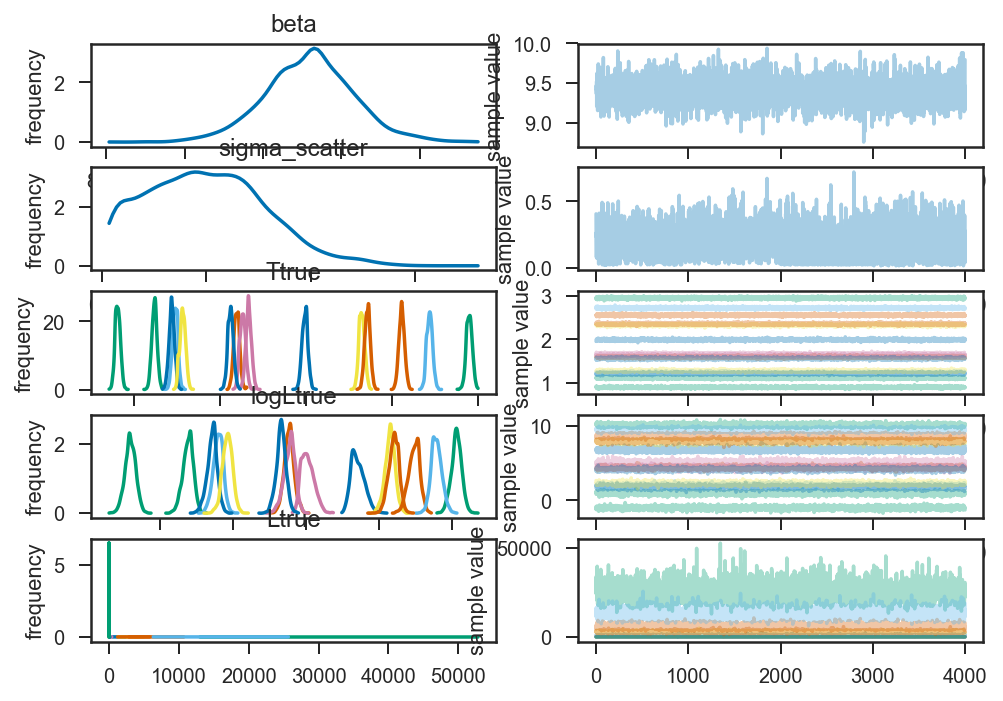

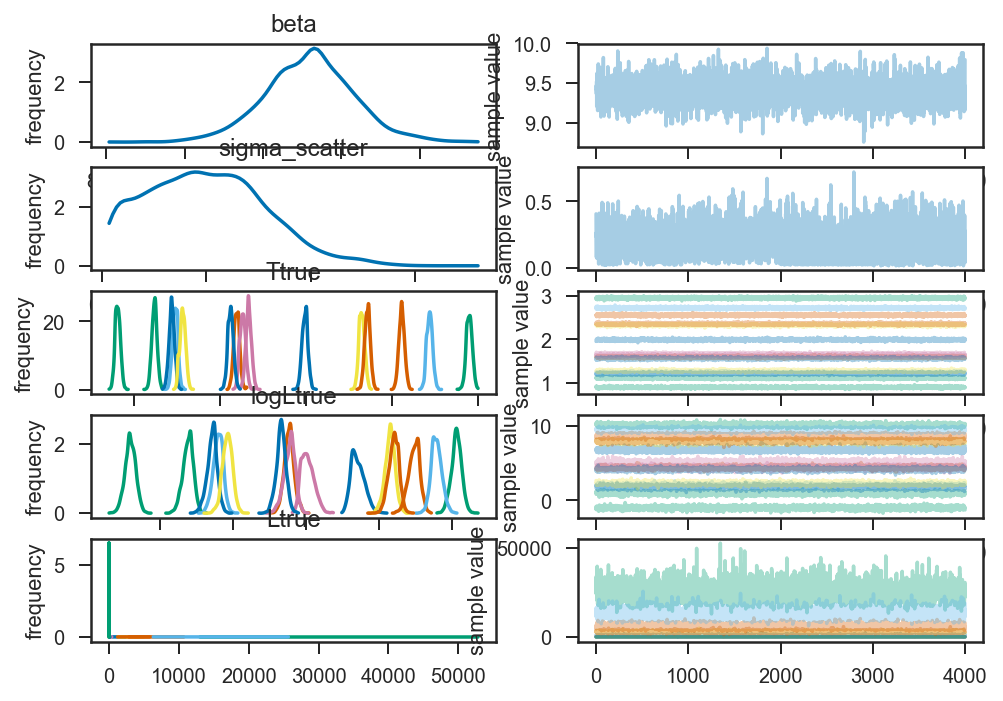

In [121]:
ms_scatter_fit.plot()

In [122]:
ms_scatter_chain = ms_scatter_fit.extract()

Our uncertainty on $\beta$ has gotten larger, but is still reasonable:

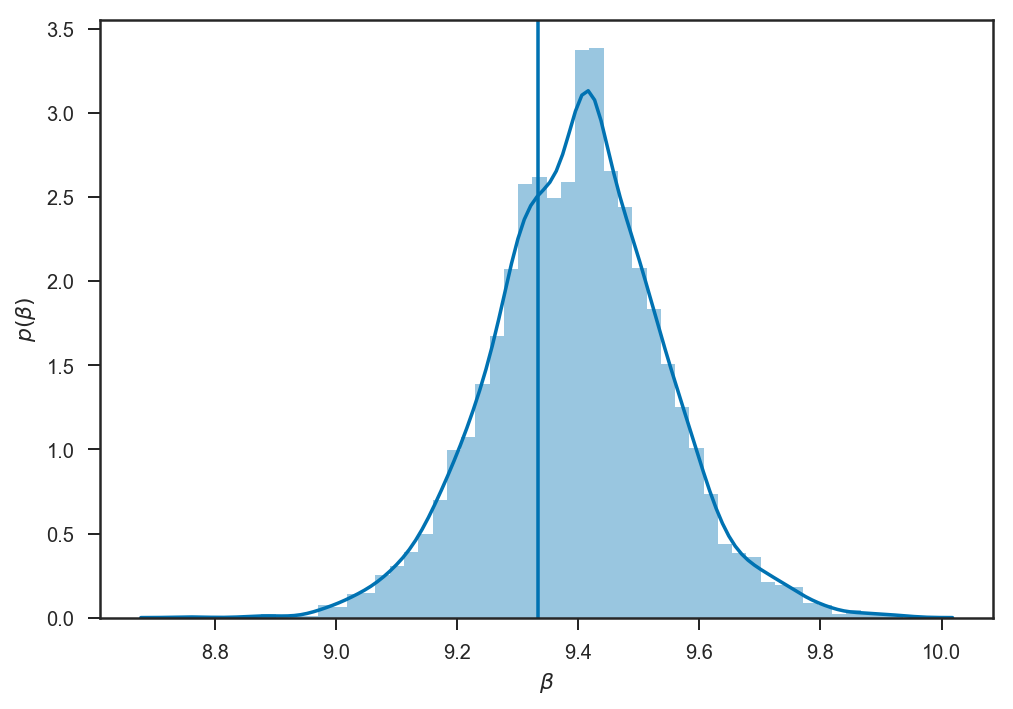

In [123]:
sns.distplot(ms_scatter_chain['beta'])
axvline(28/3, color=sns.color_palette()[0])
xlabel(r'$\beta$')
ylabel(r'$p(\beta)$')

We do a reasonable job of inferring the amount of scatter, too:

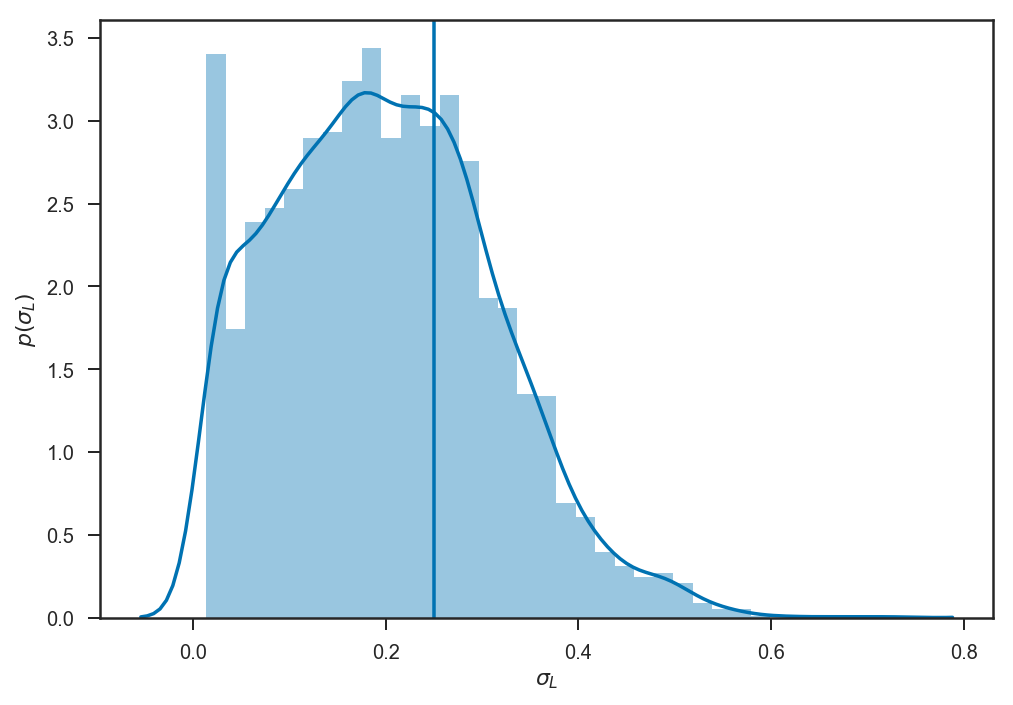

In [124]:
sns.distplot(ms_scatter_chain['sigma_scatter'])
axvline(0.25, color=sns.color_palette()[0])
xlabel(r'$\sigma_L$')
ylabel(r'$p\left( \sigma_L \right)$')

Our fit in data space:

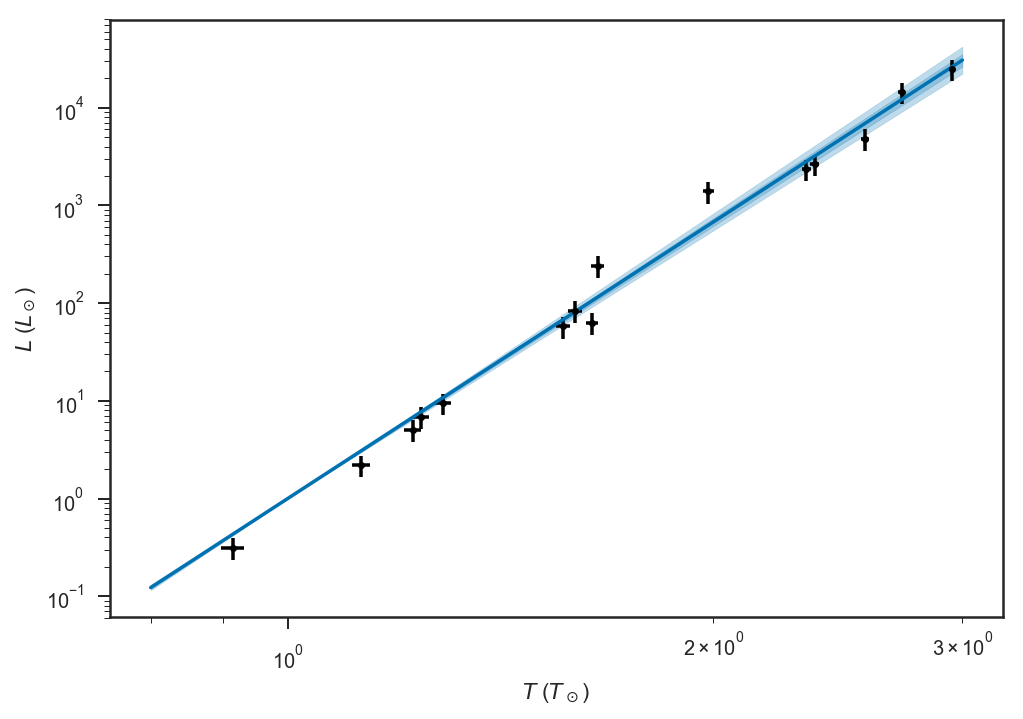

In [125]:
Ts_plot = linspace(0.8, 3, 100)
Ls_plot = []
for b in ms_scatter_chain['beta']:
    Ls_plot.append(Ts_plot**b)
Ls_plot = array(Ls_plot)

errorbar(Ts_obs, exp(logLs_obs), xerr=sigma_T, yerr=sigma_logL*exp(logLs_obs), fmt='.', color='k')
plot(Ts_plot, median(Ls_plot, axis=0))
fill_between(Ts_plot, percentile(Ls_plot, 84, axis=0), percentile(Ls_plot, 16, axis=0), color=sns.color_palette()[0], alpha=0.25)
fill_between(Ts_plot, percentile(Ls_plot, 97.5, axis=0), percentile(Ls_plot, 2.5, axis=0), color=sns.color_palette()[0], alpha=0.25)
xscale('log')
yscale('log')
xlabel(r'$T$ ($T_\odot$)')
ylabel(r'$L$ ($L_\odot$)')

We still get mildly improved estimates of the true $L$, but the improvement is not as dramatic since we now have as much "intrinsic scatter" as we do observational error, and the former cannot be improved upon by reliable $T$ measurements.

<Container object of 3 artists>

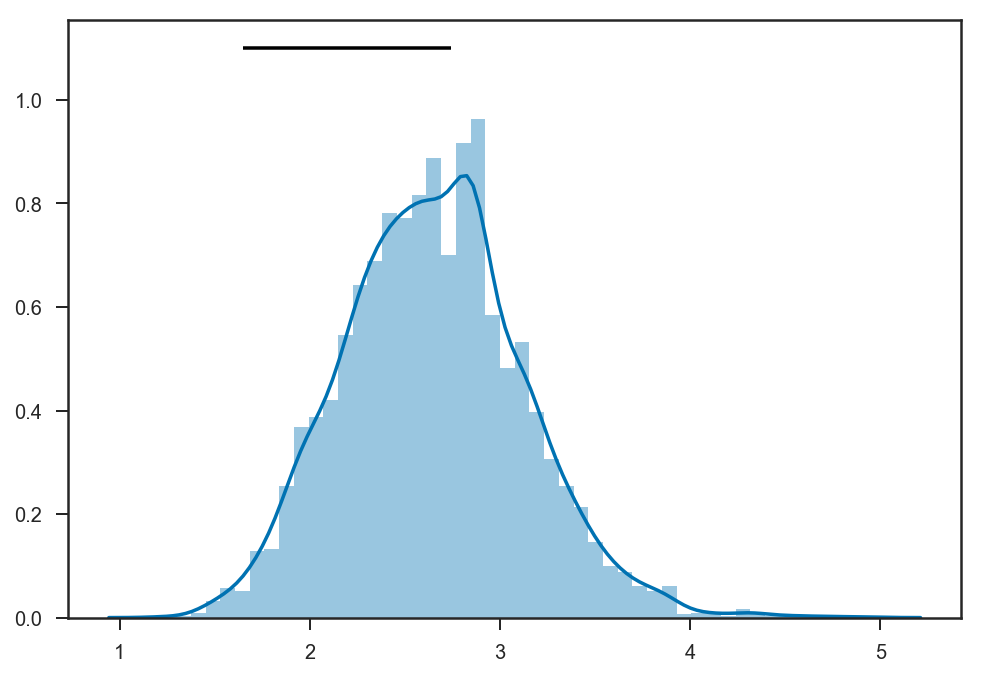

In [128]:
sns.distplot(ms_scatter_chain['Ltrue'][:,1])
errorbar(exp(logLs_obs[1]), 1.1, xerr=sigma_logL*exp(logLs_obs[1]), color='k')

## Fitting the IMF

In a real population of stars, the distribution of temperatures would not be uniform, but instead would follow an (approximate) power law.  This follows from the fact that the mass-temperature relation is approximately power-law ($T \sim M^{3/8}$) and the initial mass function is also a [Salpeter power law](https://ui.adsabs.harvard.edu/#abs/1955ApJ...121..161S/abstract) $\mathrm{d}N/\mathrm{d}M \sim M^{-2.35}$.  Combining these, we find 
$$
\frac{\mathrm{d}N}{\mathrm{d} T} \sim \frac{\mathrm{d}N}{\mathrm{d} M} \frac{\mathrm{d} M}{\mathrm{d} T} \sim M^{-2.35} T^{5/3} \sim T^{-4.6}
$$
We can specify this as our prior on $T$ instead of the uniform prior we have been using and simultaneously extract the main-sequence slope and the IMF slope.  We build on the "scatter" model above.  The model is in ``ms-imf.stan``.  

We assume 
$$
\frac{\mathrm{d} N}{\mathrm{d} T} \sim T^{-(\gamma + 1)} \sim T^{-8 \alpha / 3 + 5/3}
$$
treating $\gamma > 0$ as a parameter and also reporting an induced posterior on $\alpha$ (which corresponds to the mass power law).

In [133]:
ms_imf_model = pystan.StanModel(file='ms-imf.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7b723017363f0e0b1521ad0d64dae774 NOW.


As before, we draw data; this time, let's observe more stars than before:

In [135]:
sigma_T = 0.017 # Solar units
sigma_logL = 0.25
sigma_scatter = 0.25

beta_true = 28.0/3.0
gamma_true = 3.6

Nobs = 50

U = random.uniform(low=3**(-gamma_true), high=0.8**(-gamma_true), size=Nobs)
Ts_true = U**(-1.0/gamma_true)
Ls_true = Ts_true**beta_true*exp(sigma_scatter*randn(Nobs))
logLs_true = log(Ls_true)

Ts_obs = Ts_true + sigma_T*randn(Nobs)
logLs_obs = logLs_true + sigma_logL*randn(Nobs)

You can see that now there are a lot more low-temperature stars than high-temperature, as we would find in a real observation:

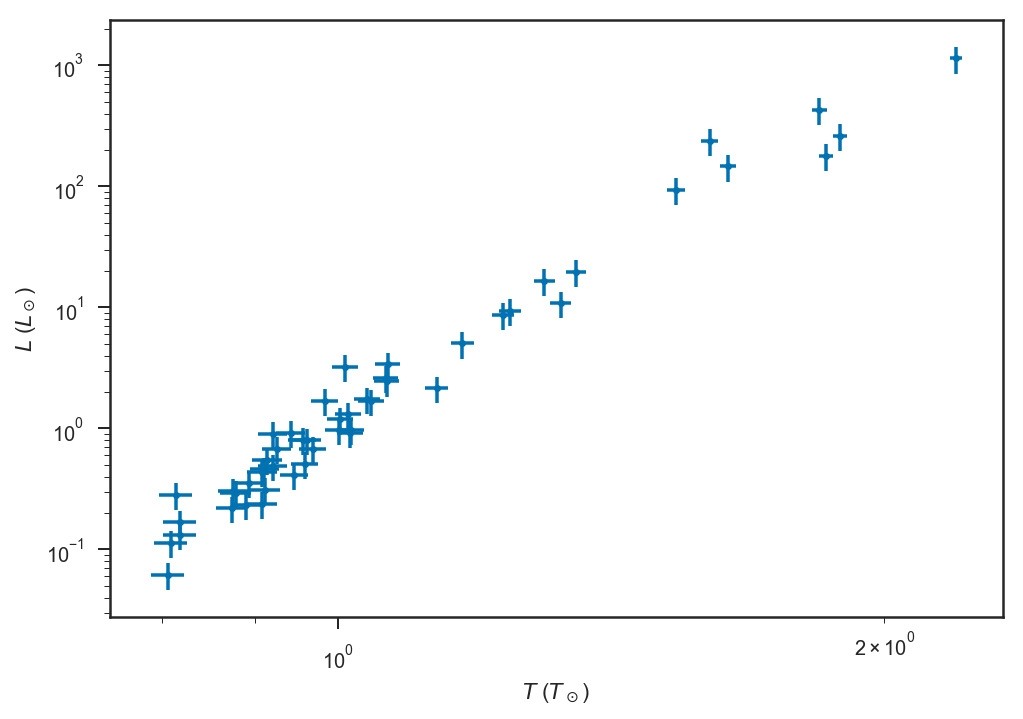

In [136]:
errorbar(Ts_obs, exp(logLs_obs), xerr=sigma_T, yerr=sigma_logL*exp(logLs_obs), fmt='.')
xscale('log')
yscale('log')
xlabel(r'$T$ ($T_\odot$)')
ylabel(r'$L$ ($L_\odot$)')

We fit it:

In [137]:
ms_imf_data = {
    'Nobs': Nobs,
    'logLobs': logLs_obs,
    'sigma_logL': sigma_logL*ones_like(logLs_obs),
    'Tobs': Ts_obs,
    'sigma_Tobs': sigma_T*ones_like(Ts_obs)
}

In [138]:
ms_imf_fit = ms_imf_model.sampling(data=ms_imf_data)

/Users/farr/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [139]:
ms_imf_fit

Inference for Stan model: anon_model_7b723017363f0e0b1521ad0d64dae774.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta            9.54  3.8e-3   0.22   9.11    9.4   9.54   9.68   9.99   3282    1.0
gamma           3.52  7.6e-3   0.48   2.63   3.19    3.5   3.83   4.55   4000    1.0
sigma_scatter   0.28  1.8e-3   0.06   0.17   0.25   0.28   0.32    0.4   1103    1.0
Ttrue[0]        0.94  2.5e-4   0.02   0.91   0.93   0.94   0.95   0.97   4000    1.0
Ttrue[1]        1.61  2.6e-4   0.02   1.58    1.6   1.61   1.62   1.65   4000    1.0
Ttrue[2]        1.07  2.5e-4   0.02   1.04   1.06   1.07   1.08    1.1   4000    1.0
Ttrue[3]        0.91  2.4e-4   0.02   0.88    0.9   0.91   0.92   0.94   4000    1.0
Ttrue[4]        1.07  2.5e-4   0.02   1.04   1.06   1.07   1.08    1.1   4000    1.0
Ttrue[5]        0.93  2.5e-4   0.02    0.9   0

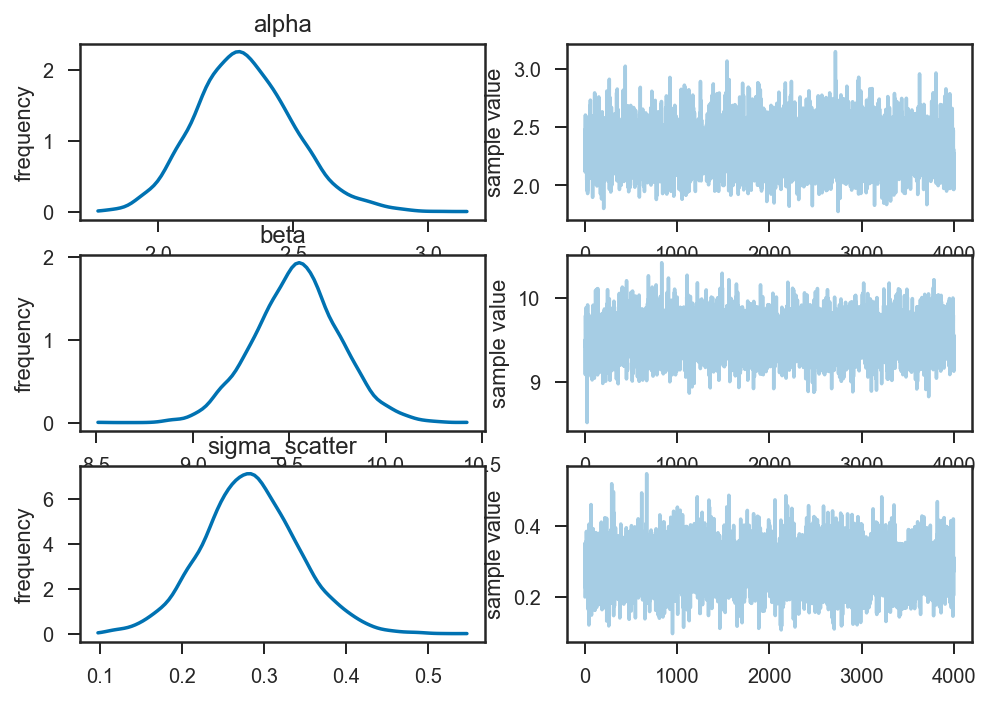

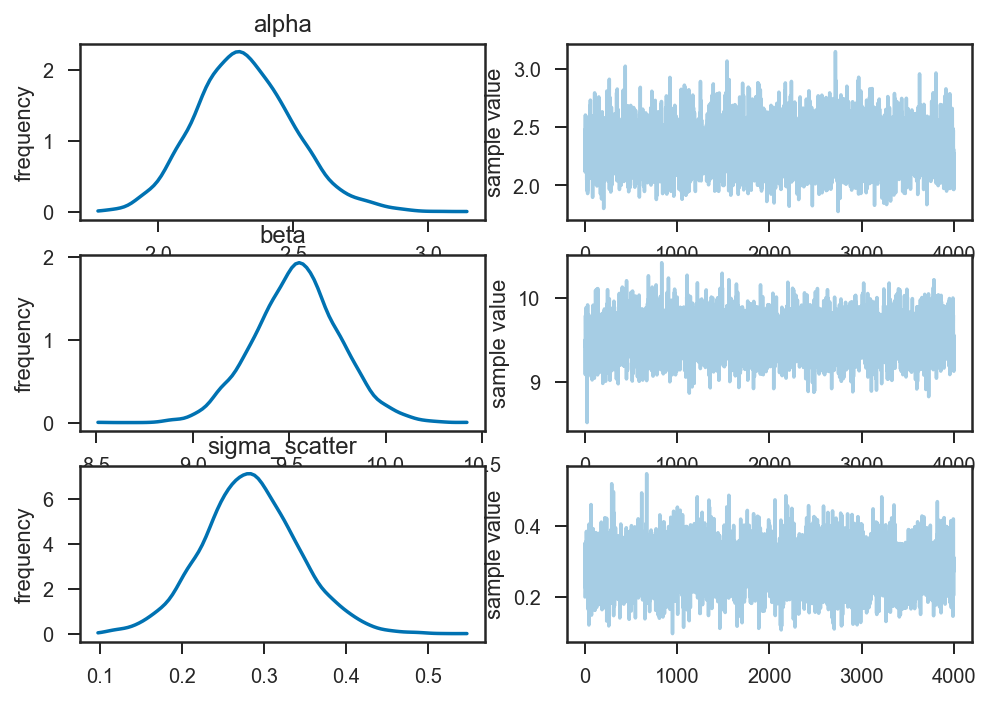

In [140]:
ms_imf_fit.plot(['alpha', 'beta', 'sigma_scatter'])

And we reliably extract the MS slope and the Salpeter IMF slope:

In [141]:
ms_imf_chain = ms_imf_fit.extract()

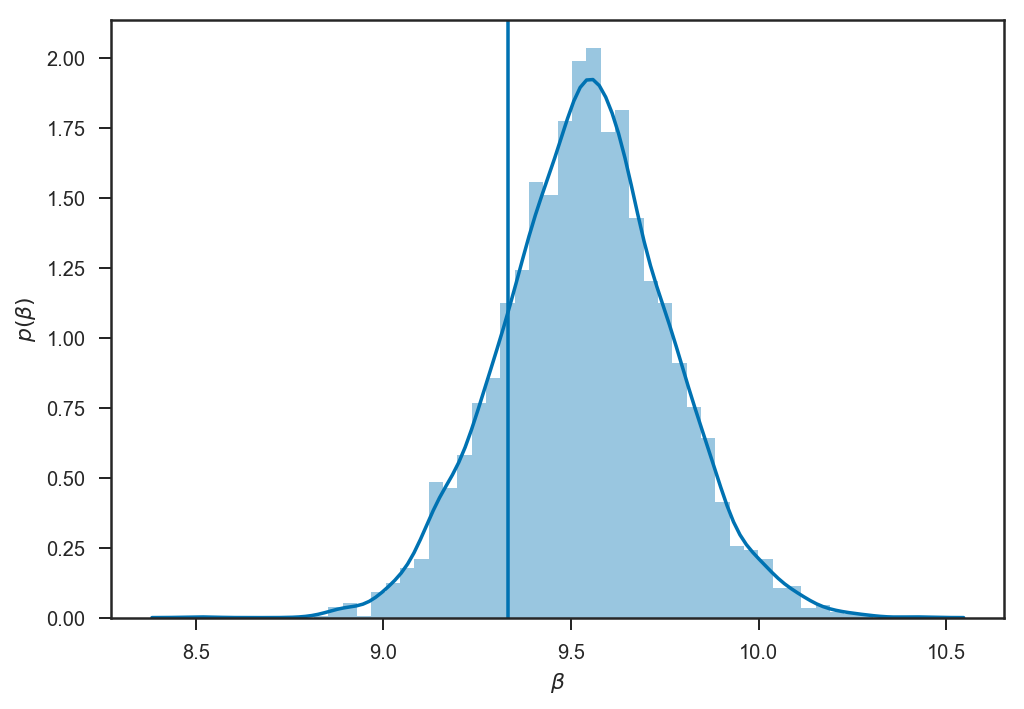

In [142]:
sns.distplot(ms_imf_chain['beta'])
axvline(28/3, color=sns.color_palette()[0])
xlabel(r'$\beta$')
ylabel(r'$p(\beta)$')

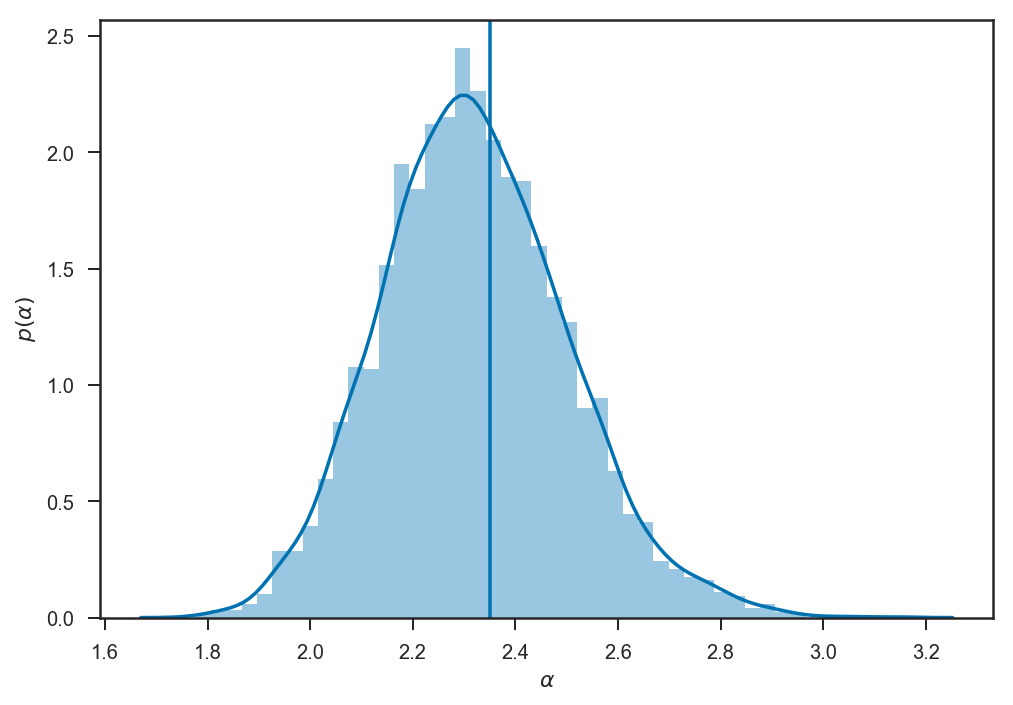

In [144]:
sns.distplot(ms_imf_chain['alpha'])
axvline(2.35, color=sns.color_palette()[0])
xlabel(r'$\alpha$')
ylabel(r'$p\left(\alpha\right)$')

The fit for the main sequence looks pretty good to me:

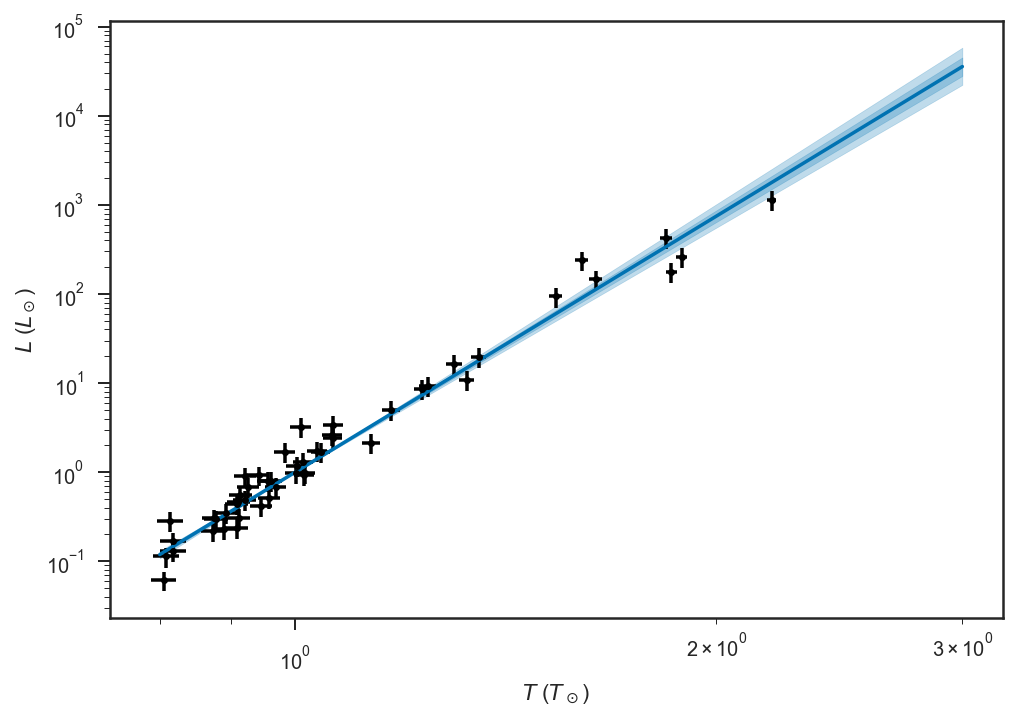

In [146]:
Ts_plot = linspace(0.8, 3, 100)
Ls_plot = []
for b in ms_imf_chain['beta']:
    Ls_plot.append(Ts_plot**b)
Ls_plot = array(Ls_plot)

errorbar(Ts_obs, exp(logLs_obs), xerr=sigma_T, yerr=sigma_logL*exp(logLs_obs), fmt='.', color='k')
plot(Ts_plot, median(Ls_plot, axis=0))
fill_between(Ts_plot, percentile(Ls_plot, 84, axis=0), percentile(Ls_plot, 16, axis=0), color=sns.color_palette()[0], alpha=0.25)
fill_between(Ts_plot, percentile(Ls_plot, 97.5, axis=0), percentile(Ls_plot, 2.5, axis=0), color=sns.color_palette()[0], alpha=0.25)
xscale('log')
yscale('log')
xlabel(r'$T$ ($T_\odot$)')
ylabel(r'$L$ ($L_\odot$)')